# Bayesian Optimization (3)

This time I included the spinal canal, lungs, heart, chest, ribs, and the PTV.

* Treatment plan score: Sum of the percent difference in dose from all clinical goals for the included OARs and PTVs. For clinical goals with an upper (lower) bound, we minimize the percent increase (decrease). 
* Parameters: Dose values for all OAR objectives (but not volume parameters for those with DVH objectives). For each parameter, I searched over the range that included 50-100% of the clinical goal upper bound.

Overall, the resulting plan decreases OAR values compared to the approved plan, at the expense of increasing PTV values.

Thoughts: 
* Some OARs have multiple clinical goals that may be redundant, and including all of them may bias the score towards their improvement over that of other OARs.
* Most OAR parameters converged to values on the boundaries of the search space, so we can probably improve by increasing the range. However, if we go too low, RayStation often throws Exceptions. In those cases, I gave a score of 1e6, but I suspect this can have negative effects on the surrogate function used in the optimization.
* Stopping criteria? Callback to save progress in case of interruption?

Things to save from future runs:
* Clinical goal values for each ROI each iteration
* Clinical goal values for approved plan (and score)
* Anything else?

## Clinical Goals

* Spinal canal: At most 2080 cGy dose at 0.35 cm$^3$ volume
* Lungs: At most 10% volume at 2000 cGy dose, At most 1500 cm$^3$ volume at 1160 cGy dose
* Heart: At most 15 cm$^3$ volume at 2800 cGy dose, At most 3400 cGy dose at 0 cm$^3$ volume
* Chest: At most 30 cm$^3$ volume at 3000 cGy dose
* Ribs: At most 1 cm$^3$ volume at 3200 cGy ddose,  At most 000 cGy dose at 0.04 cm$^3$ volume
* PTV: At least 95% volume at 4800 cGy, At least 99% volume at 4320 cGy dose

## Objective Functions

* Spinal canal: Max Dose 2080 cGy
* Lungs: Max DVH 2000 cGy to 10% volume
* Heart: Max Dose 2800 cGy
* Chest: Max DVH 3000 cGy to 1.5% volume
* Ribs: Max Dose 3200 cGy
* PTV: Max Dose 6240 cGy, Min Dose 4800 cGy

In [1]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Approved results
stats_approved = np.load('approved/stats.npy', allow_pickle=True).item()
dvh_approved = np.load('approved/dvh.npy', allow_pickle=True).item()

In [3]:
# Optimization results
stats = np.load('multi_oar/stats.npy', allow_pickle=True).item()
dvh = np.load('multi_oar/dvh.npy', allow_pickle=True).item()
fun = np.load('multi_oar/fun.npy')
func_vals = np.load('multi_oar/func_vals.npy')
x = np.load('multi_oar/x.npy')
x_iters = np.load('multi_oar/x_iters.npy')

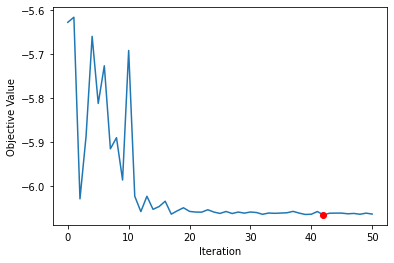

In [4]:
# Objective values
idx = np.argmin(func_vals)
plt.plot(func_vals)
plt.plot(idx, func_vals[idx], 'ro')
plt.xlabel('Iteration')
plt.ylabel('Objective Value');

# What is the score of the approved plan?

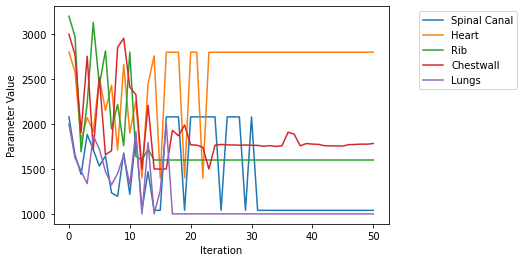

In [5]:
# Parameter values
oar_list = ['Spinal Canal', 'Heart', 'Rib', 'Chestwall', 'Lungs']
for ii in range(x_iters.shape[1]):
    plt.plot(x_iters[:, ii])
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend(labels=oar_list, bbox_to_anchor=[1.4, 1]);

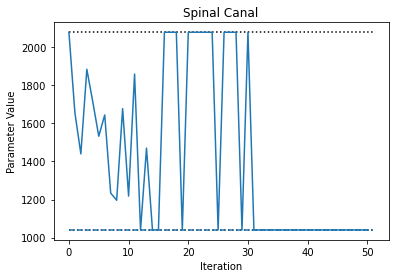

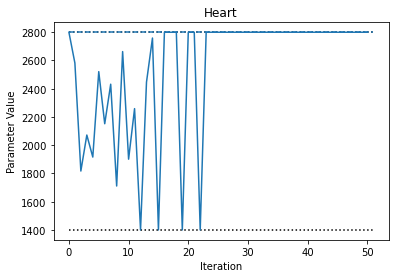

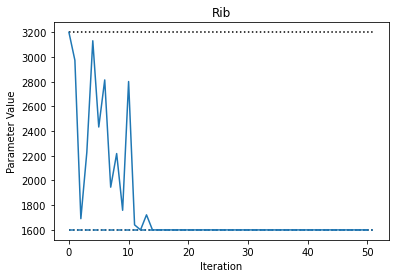

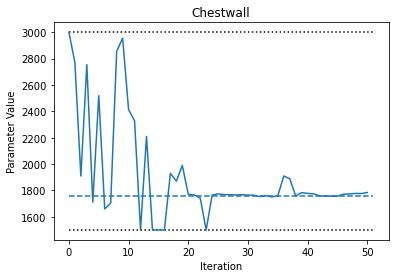

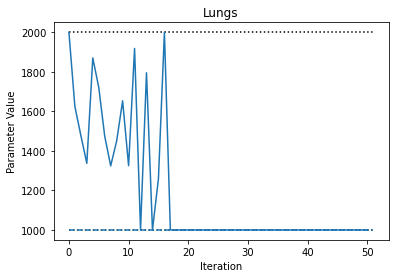

In [6]:
# Parameter values
colors = cm.tab10.colors
for ii in range(x_iters.shape[1]):
    plt.figure()
    plt.plot([0, x_iters.shape[0]], [x_iters[0, ii], x_iters[0, ii]], 'k:')
    plt.plot([0, x_iters.shape[0]], [0.5*x_iters[0, ii], 0.5*x_iters[0, ii]], 'k:')
    plt.plot([0, x_iters.shape[0]], [x[ii], x[ii]], '--', color=colors[0])
    plt.plot(x_iters[:, ii], color=colors[0])
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.title(oar_list[ii])
    
# Except for chest wall, all other parameters ended up on one of the boundaries,
# meaning there is a good change we could improve the plan by expanding the parameter ranges.

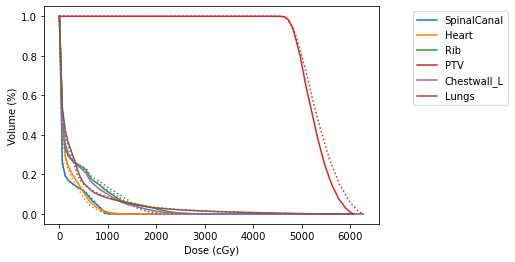

In [7]:
# Dose-volume histograms
handles = []
colors = cm.tab10.colors
roi_list = list(dvh.keys())[1:]
for ii in range(len(roi_list)):
    line, = plt.plot(dvh_approved['Dose'], dvh_approved[roi_list[ii]], color=colors[ii])
    plt.plot(dvh['Dose'], dvh[roi_list[ii]], ':', color=colors[ii])
    handles.append(line)
plt.xlabel('Dose (cGy)')
plt.ylabel('Volume (%)')
plt.legend(handles=handles, labels=roi_list, bbox_to_anchor=[1.4, 1]);

# Approved plan in solid lines
# My plan in dotted lines

In [8]:
# Percent change from approved plan
idx = 0
for roi in roi_list:
    print(roi)
    for val in ['Min', 'Average', 'Max']:
        diff = (stats[roi][val] - stats_approved[roi][val])/stats_approved[roi][val]
        print(f'Percent Change for {val}: {100*diff:.2f}')
    print()

SpinalCanal
Percent Change for Min: -3.83
Percent Change for Average: -0.51
Percent Change for Max: -9.86

Heart
Percent Change for Min: -18.12
Percent Change for Average: -12.12
Percent Change for Max: -12.11

Rib
Percent Change for Min: -39.78
Percent Change for Average: 0.63
Percent Change for Max: -26.48

PTV
Percent Change for Min: -1.21
Percent Change for Average: 1.78
Percent Change for Max: 3.42

Chestwall_L
Percent Change for Min: -39.78
Percent Change for Average: 4.14
Percent Change for Max: -13.87

Lungs
Percent Change for Min: -5.24
Percent Change for Average: -1.14
Percent Change for Max: 3.25

